In [2]:
import os
os.environ['http_proxy'] = "http://192.41.170.23:3128" 
os.environ['https_proxy'] = "http://192.41.170.23:3128" 
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [3]:
import torch
device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch.cuda.get_device_name(device)

'NVIDIA RTX A6000'

In [4]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer, AutoModelForSequenceClassification
text = "This is a great [MASK]."
#text = "The capital of France is [MASK]."
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)

In [5]:
### ALL token Fill
inputs = tokenizer(text, return_tensors="pt").to(device)
token_logits = model(**inputs).logits
# Find the location of [MASK] and extract its logits
mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
mask_token_logits = token_logits[0, mask_token_index, :]
# Pick the [MASK] candidates with the highest logits

top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

for token in top_5_tokens:
    print(f"'>>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}'",token)

'>>> This is a great deal.' 3066
'>>> This is a great success.' 3112
'>>> This is a great adventure.' 6172
'>>> This is a great idea.' 2801
'>>> This is a great feat.' 8658


# Template 

In [5]:
# # template must have 3 things : input, symbol, mask token 
# s1,s2,s3,s4 = ":" , ">" , "-" , "," 
# mask = " [MASK]"
# inputs =  "xxx" 
# t1 = inputs + s1 + mask 
# t2 = inputs + s2 + mask 
# t3 = inputs + s3 + mask 
# t4 = inputs + s4 + mask 

In [6]:
# # find verbalizer token 
# ids_labels = tokenizer.convert_tokens_to_ids(['good','bad'])
# print(tokenizer.convert_ids_to_tokens(ids_labels) , ids_labels)

In [7]:
# from transformers import AutoModelForMaskedLM
# from transformers import AutoTokenizer, AutoModelForSequenceClassification
# text = "This is a great [MASK]."
# #text = "The capital of France is [MASK]."
# model_checkpoint = "distilbert-base-uncased"
# tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
# model = AutoModelForMaskedLM.from_pretrained(model_checkpoint).to(device)

In [8]:
# prompts = tokenizer(t1,padding=True ,return_tensors="pt").to(device)
# token_logits = model(**prompts).logits

# # Find the location of [MASK] and extract its logits
# mask_token_index = torch.where(prompts["input_ids"] == tokenizer.mask_token_id)[1]
# mask_token_logits = token_logits[0, mask_token_index, ids_labels]

# # sort 
# sort_scores = torch.argsort(mask_token_logits,descending=True)
# scores = torch.argmax(mask_token_logits)
# print(scores)

# for idx in sort_scores:
#     token = ids_labels[idx]
#     print(f"'{t1.replace(tokenizer.mask_token, tokenizer.decode([token]))}'",idx)
#           #,token_logits[0, mask_token_index, ids_labels[idx]])

# sst2 

In [6]:
from datasets import load_dataset
sst = load_dataset("sst2")
sst 

Found cached dataset sst2 (/home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 67349
    })
    validation: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 872
    })
    test: Dataset({
        features: ['idx', 'sentence', 'label'],
        num_rows: 1821
    })
})

In [7]:
trainsst = sst['train']
valsst = sst['validation']
testsst = sst['test']
trainsst

Dataset({
    features: ['idx', 'sentence', 'label'],
    num_rows: 67349
})

In [8]:
prompts = list(map(lambda sentence : sentence + ": " + "[MASK]" , trainsst["sentence"]))
trainsst = trainsst.add_column('prompts',prompts)
trainsst = trainsst.remove_columns(['sentence'])
trainsst

Dataset({
    features: ['idx', 'label', 'prompts'],
    num_rows: 67349
})

In [9]:
from transformers import AutoTokenizer , AutoModelForMaskedLM

model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def tokenize_function(examples):
    return tokenizer(examples["prompts"], padding="max_length", truncation=True)

tokenized_datasets = trainsst.map(tokenize_function, batched=True)
#tokenized_datasets.set_format("torch")
tokenized_datasets

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-22c6c97846910931.arrow


Dataset({
    features: ['idx', 'label', 'prompts', 'input_ids', 'attention_mask'],
    num_rows: 67349
})

In [10]:
tokenized_datasets = tokenized_datasets.shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-591166e83dd646fa.arrow


In [11]:
# making label for Masking task. 0 : negative , 1 : positive 
def adjust_label(dataset):
    # dataset might NOT covert to tensor format.
    label_0 = tokenizer("negative")["input_ids"][1]
    label_1 = tokenizer("positive")["input_ids"][1]
    
    pad_length = len(dataset["input_ids"][0])
    num_sample = len(dataset)
    mock_labels = [[-100]*pad_length]*num_sample
    mock_labels = torch.LongTensor(mock_labels)
    # x = x.add_column('la99',mock_labels)
    dataset.set_format("torch")
    
    # repalce value in labels array for tranform to MLM patterns
    for i in range(len(dataset)) :
        cls_token_index = torch.where(dataset["input_ids"][i] == tokenizer.cls_token_id)
        cls_token_index = cls_token_index[0].item()
        mock_labels[i][cls_token_index] = tokenizer.cls_token_id

        sep_token_index = torch.where(dataset["input_ids"][i] == tokenizer.sep_token_id)
        sep_token_index = sep_token_index[0].item()
        mock_labels[i][sep_token_index] = tokenizer.sep_token_id

        mask_token_index = torch.where(dataset["input_ids"][i] == tokenizer.mask_token_id)
        mask_token_index = mask_token_index[0].item()
        if dataset['label'][i] == 0 : 
            mock_labels[i][mask_token_index] = label_0
        elif  dataset['label'][i] == 1 :
            mock_labels[i][mask_token_index] = label_1
        else :
            assert False , "something wrong!!"
        
        if i == num_sample/2 :
            print("Half",i)    
    dataset = dataset.add_column('labels',mock_labels.tolist())
    
    return dataset

In [12]:
tokenized_datasets = adjust_label(tokenized_datasets)
tokenized_datasets

Half 500


Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-c74fea95c2efd305.arrow


Dataset({
    features: ['idx', 'label', 'prompts', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [13]:
tokenized_datasets = tokenized_datasets.remove_columns(["prompts","idx",'label'])
tokenized_datasets

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 1000
})

In [14]:
small_train_dataset = tokenized_datasets.shuffle(seed=42).select(range(1000))

Loading cached shuffled indices for dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-ebd389442589be89.arrow


In [15]:
def token_data(dataset):
    prompts = list(map(lambda sentence : sentence + ": " + "[MASK]" , dataset["sentence"]))
    dataset = dataset.add_column('prompts',prompts)
    dataset = dataset.remove_columns(['sentence'])
    
    tokenized_datasets = dataset.map(tokenize_function, batched=True)
    tokenized_datasets = adjust_label(tokenized_datasets)
    tokenized_datasets = tokenized_datasets.remove_columns(["prompts","idx",'label'])
    
    return tokenized_datasets

In [16]:
eval_dataset = token_data(valsst)
small_eval_dataset = eval_dataset.shuffle(seed=42).select(range(500))

Loading cached processed dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-6654bfb7d3714800.arrow


Half 436


Loading cached shuffled indices for dataset at /home/arnajakt/.cache/huggingface/datasets/sst2/default/2.0.0/9896208a8d85db057ac50c72282bcb8fe755accc671a57dd8059d4e130961ed5/cache-2da5f972ca5824e5.arrow


In [17]:
from torch.utils.data import DataLoader
batch_size = 8 
train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=batch_size)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=batch_size)

In [18]:
# Just check 
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'input_ids': torch.Size([8, 512]),
 'attention_mask': torch.Size([8, 512]),
 'labels': torch.Size([8, 512])}

In [19]:
batch['input_ids'].dtype

torch.int64

In [68]:
from transformers import AutoModelForMaskedLM
model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [69]:
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5)

In [70]:
from accelerate import Accelerator

accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [71]:
from transformers import get_scheduler

num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [72]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
torch.cuda.get_device_name(device)

'NVIDIA RTX A6000'

In [76]:
from tqdm.auto import tqdm
import torch
import math

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()} 
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))
    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # # Save and upload
    # accelerator.wait_for_everyone()
    # unwrapped_model = accelerator.unwrap_model(model)
    # unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    # if accelerator.is_main_process:
    #     tokenizer.save_pretrained(output_dir)
    #     repo.push_to_hub(
    #         commit_message=f"Training in progress epoch {epoch}", blocking=False
    #     )
    
#     if epoch % 1000 == 0:
#         print(f">>> Epoch {epoch}: Perplexity: {perplexity}")
#         model.save_pretrained("model/model_ver1601_epoch"+str(epoch), from_pt=True)
# model.save_pretrained("model/model_lastver", from_pt=True)

  0%|          | 0/375 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 1.141173411003191
>>> Epoch 1: Perplexity: 1.141173411003191
>>> Epoch 2: Perplexity: 1.141173411003191


In [84]:
outputs.logits.shape

torch.Size([4, 512, 30522])

In [73]:
def train_model(model,train_dataloader):
    model.train()
    progress_bar = tqdm(range(num_update_steps_per_epoch))
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()} 
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)
        
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
    return model 

def eval_model(model,eval_dataloader):
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))
    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")
    return model , perplexity 

In [ ]:
from tqdm.auto import tqdm
import torch
import math

#progress_bar = tqdm(range(num_training_steps))
model_1 = model 
perplexities = [] 
for epoch in range(num_train_epochs):

    model_1 = train_model(model_1,train_dataloader)
    model_1 , perplexity =  eval_model(model_1,eval_dataloader)
    print(perplexity)
    perplexities.append(perplexity)
    
    # if valid_loss < best_valid_loss:
    # best_valid_loss = valid_loss
    # torch.save(model.state_dict(),'tensor.pt')
    

  0%|          | 0/125 [00:00<?, ?it/s]

1.1490382111799535


  0%|          | 0/125 [00:00<?, ?it/s]

1.1227902939862608


  0%|          | 0/125 [00:00<?, ?it/s]

1.141173411003191


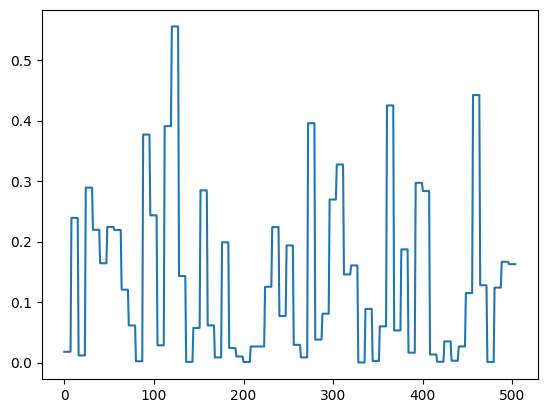

In [53]:
import matplotlib.pyplot as plt
plt.plot(losses.cpu()) # e2 

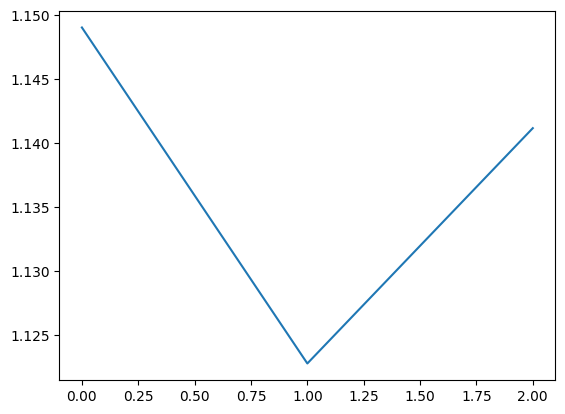

In [ ]:
import matplotlib.pyplot as plt
plt.plot(perplexities) 

In [66]:
perplexities

[1.2474709061490554, 1.2474709061490554, 1.2474709061490554]

In [38]:
504/63

8.0

In [54]:
num_train_epochs

2

In [55]:
math.exp(torch.mean(losses))

1.1483905827525371